# ATSC-411 - SYNOPTIC METEOROLOGY | PV LAB


**************

## IMPORT LIBRARIES


In [1]:
# import packages
import numpy as np                               # numpy for math & number operations
import cartopy.crs as ccrs                       # cartopy coordinate refrence system for mapping -- to turn a matplotlib axis into a geoaxis (map)
import cartopy.feature as cfeature               # cartopy features (borders, states, oceans, rivers, etc) for mapping -- add map components to a map
import matplotlib.pyplot as plt                  # matplotlib for plotting figures, axes, graphs, etc
from matplotlib.colors import LinearSegmentedColormap

import helper_functions as helper
import metpy.calc as mpcalc
from metpy.units import units
from metpy.interpolate import cross_section
from metpy.interpolate import interpolate_to_isosurface
import metpy

print("[+] packages imported...")

[+] packages imported...


/research/modules/mpich/miniconda3/lib/python3.9/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


**************

## LOAD RAP REANALYSIS DATA FOR A GIVEN DATE

In [2]:
# date/time components
year  = "2024"
month = "02"
day   = "26"
hour  = "18"


# load an `xarray` dataset of RAP reanalysis data
# this will take a few seconds to load
rap_data = helper.give_me_rap_data(year, month, day, hour)


print("\n[+] data load complete...")

> RAP REANALYSIS DATA ACCESS FUNCTION --
-----------------------------------------
> DATASET USED: RAP_13km_anl
> COMPLETE --------
> RUNTIME: 00:00:26

[+] data load complete...


**************

## Compute plan-view map variables
#### Compute potential temperature, lat/lon grid deltas, potential vorticity, theta and wind on a 2PVU isosurface and geopotential hgt slices

In [3]:
print(rap_data)

<xarray.Dataset>
Dimensions:                                   (time: 1, isobaric: 37, y: 324,
                                               x: 451, height_above_ground: 1,
                                               height_above_ground2: 2)
Coordinates:
  * time                                      (time) datetime64[ns] 2024-02-2...
  * isobaric                                  (isobaric) float32 1e+04 ... 1e+05
  * y                                         (y) float32 -412.8 ... 3.962e+03
  * x                                         (x) float32 -3.332e+03 ... 2.76...
  * height_above_ground                       (height_above_ground) float32 2.0
  * height_above_ground2                      (height_above_ground2) float32 ...
Data variables: (12/13)
    Geopotential_height_isobaric              (time, isobaric, y, x) float32 ...
    LambertConformal_Projection               int32 ...
    lat                                       (y, x) float64 ...
    lon                         

In [4]:
#################################
# COMPUTE THETA AND PV
################################# 
rap_data['dewpoint'] = mpcalc.dewpoint_from_relative_humidity(rap_data['Temperature_isobaric'], rap_data['Relative_humidity_isobaric'])
# use metpy to compute theta & add it into the `rap-data` DataSet
rap_data['theta'] = mpcalc.potential_temperature(rap_data['isobaric'],rap_data['Temperature_isobaric'])
rap_data['theta_e'] = mpcalc.equivalent_potential_temperature(rap_data['isobaric'],rap_data['Temperature_isobaric'],rap_data['dewpoint'])
rap_data['theta_sfc'] = mpcalc.potential_temperature(rap_data['MSLP'],rap_data['Temperature_height_above_ground'])
rap_data['theta_e_sfc'] = mpcalc.equivalent_potential_temperature(rap_data['MSLP'],
                                                                  rap_data['Temperature_height_above_ground'][0][0],
                                                                  rap_data['Dewpoint_temperature_height_above_ground'][0][0])

rap_data['wind_speed'] = mpcalc.wind_speed(rap_data['u-component_of_wind_isobaric'], rap_data['v-component_of_wind_isobaric'])

# use metpy to compute latitude / longitude grid deltas (dx, dy) for PV calculation
dx, dy = mpcalc.lat_lon_grid_deltas(rap_data['lon'].values, rap_data['lat'].values)

# use metpy to compute PV and add it into the `rap_data` DataSet
rap_data['pv'] = mpcalc.potential_vorticity_baroclinic(rap_data['theta'],
                                                        rap_data['isobaric'],
                                                        u=rap_data['u-component_of_wind_isobaric'],
                                                        v=rap_data['v-component_of_wind_isobaric'],
                                                        dx=dx[None, None, :, :], dy=dy[None, None, :, :],
                                                        latitude=rap_data['lat'])

thta_on_2pvu = interpolate_to_isosurface(rap_data['pv'].values, rap_data['theta'].values,  2*1e-6, bottom_up_search=True)
u_on_2pvu    = interpolate_to_isosurface(rap_data['pv'][:,0,:,:].values, rap_data['u-component_of_wind_isobaric'][0,:,:,:].values, 2*1e-6, bottom_up_search=True)
v_on_2pvu    = interpolate_to_isosurface(rap_data['pv'][:,0,:,:].values, rap_data['v-component_of_wind_isobaric'][0,:,:,:].values, 2*1e-6, bottom_up_search=True)

#################################
# DEFINE USEFUL PRESSURE LEVEL SLICES
################################# 
# create variables that hold the "index" (location) of a given height in the isobaric dimension
# i.e., 300 hPa is the 8th value in the isobaric dimension, use it to slice other variables
plev250 = list(rap_data['isobaric']).index(((250 * units('hPa')).to(rap_data['isobaric'].units)).m)
plev300 = list(rap_data['isobaric']).index(((300 * units('hPa')).to(rap_data['isobaric'].units)).m)
plev500 = list(rap_data['isobaric']).index(((500 * units('hPa')).to(rap_data['isobaric'].units)).m)
plev700 = list(rap_data['isobaric']).index(((700 * units('hPa')).to(rap_data['isobaric'].units)).m)
plev850 = list(rap_data['isobaric']).index(((850 * units('hPa')).to(rap_data['isobaric'].units)).m)
plev1000 = list(rap_data['isobaric']).index(((1000 * units('hPa')).to(rap_data['isobaric'].units)).m)

#################################
# CREATE A TIDY DATE STRING
################################# 
try:
    data_date = rap_data['time'].values[0]
except:
    data_date = rap_data['time1'].values[0]
    pass
valid_date = f'{data_date}'

print("\n[+] plan view data preparation complete...")


[+] plan view data preparation complete...


### **************

## Define the `build_map()`, & `build_inset_map()` functions & create custom colormaps

In [5]:
#--------------------------------------------------------------------------------------
# BUILD MAPS FUNCTION -----------------------------------------------------------------
#--------------------------------------------------------------------------------------
# define build maps func
def build_map(extent=[-121, -73, 21, 56]):
    
    fig = plt.figure(figsize=(16, 12))
    ax = plt.axes(projection=ccrs.LambertConformal())

    # apply the map extent (lat/lon bounding box)
    ax.set_extent(extent)
    # axis aspect ratio
    ax.set_box_aspect(0.7)
    # add map features
    ax.add_feature(cfeature.STATES, edgecolor='navy', alpha=0.5, linestyle='-', linewidth=1, zorder=10)
    ax.add_feature(cfeature.BORDERS, color='navy', alpha=1, linestyle='-', linewidth=1, zorder=11)
    ax.add_feature(cfeature.COASTLINE, color='navy', alpha=0.5, linestyle='-', linewidth=1, zorder=11)

    # apply tight layout to the figure (keeps things tiddy)
    plt.tight_layout()

    # return the figure axis
    return fig, ax


#--------------------------------------------------------------------------------------
# BUILD INSET MAP FUNCTION -----------------------------------------------------------------
#--------------------------------------------------------------------------------------
def build_inset_map(extent=[-121, -73, 21, 56]):

    # SET UP MAP INSET AXIS
    proj = ccrs.LambertConformal()
    ax = fig.add_axes([0.73, 0.712, 0.17, 0.17], projection=proj)
    ax.set_box_aspect(0.7)
    ax.set_extent(extent, ccrs.PlateCarree())

    ax.add_feature(cfeature.COASTLINE, edgecolor='navy', linewidth=0.5)
    ax.add_feature(cfeature.STATES, edgecolor='navy', linewidth=0.5)

    return ax




#--------------------------------------------------------------------------------------
# DEFINE COLORMAPS    -----------------------------------------------------------------
#--------------------------------------------------------------------------------------

# wind speed colormap
wdsp_colors = [(0.000, '#FFFFFF'),(0.004, '#87CEFA'),(0.166, '#6A5ACD'),(0.250, '#E696DC'),(0.333, '#C85ABE'),
          (0.416, '#A01496'), (0.500, '#C80028'), (0.583, '#DC283C'), (0.666, '#F05050'),(0.750, '#FAF064'),
          (0.833, '#DCBE46'), (0.916, '#BE8C28'),(1.000, '#A05A0A')]
wdsp_cmap = LinearSegmentedColormap.from_list("custom_cmap",wdsp_colors,N=256)

# potential vorticity colormap
pv_clevs  = np.append(np.arange(-1.4, 2, 0.2),np.arange(2,10.2,0.4))
pv_colors = ["blue","lightblue","lightblue","yellow","orange","red","darkred"]
pv_cmap   = LinearSegmentedColormap.from_list("custom_cmap",pv_colors)

# theta on the 2PVU surface colormap
theta_2pvu_colors = ["purple","lightblue","blue","green","yellow","red","darkred"]
theta_2pvu_cmap = LinearSegmentedColormap.from_list("custom_cmap", theta_2pvu_colors)


print("\n[+] functions and colormaps created...")



[+] functions and colormaps created...


In [6]:

print(rap_data['theta_e_sfc'][0])

<xarray.DataArray 'theta_e_sfc' (y: 324, x: 451)>
<Quantity([[344.57477 344.76852 344.50168 ... 342.18683 342.25024 344.92883]
 [344.84012 344.88235 344.88382 ... 345.10898 344.00925 344.40094]
 [344.91324 344.957   344.80615 ... 345.295   344.38037 344.0201 ]
 ...
 [282.92752 283.0709  283.17902 ... 270.26413 270.22424 270.13937]
 [282.94626 283.01776 283.15375 ... 270.41843 270.9177  270.36026]
 [282.89313 282.96378 283.0287  ... 271.00317 271.0319  270.6474 ]], 'kelvin')>
Coordinates:
    time     datetime64[ns] 2024-02-26T18:00:00
  * y        (y) float32 -412.8 -399.3 -385.7 ... 3.935e+03 3.949e+03 3.962e+03
  * x        (x) float32 -3.332e+03 -3.319e+03 -3.305e+03 ... 2.75e+03 2.763e+03


**************

## Surface Equivalent Potential Temperature, Winds, and Pressure


[+] plotting...


/research/modules/mpich/miniconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/research/modules/mpich/miniconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/research/modules/mpich/miniconda3/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


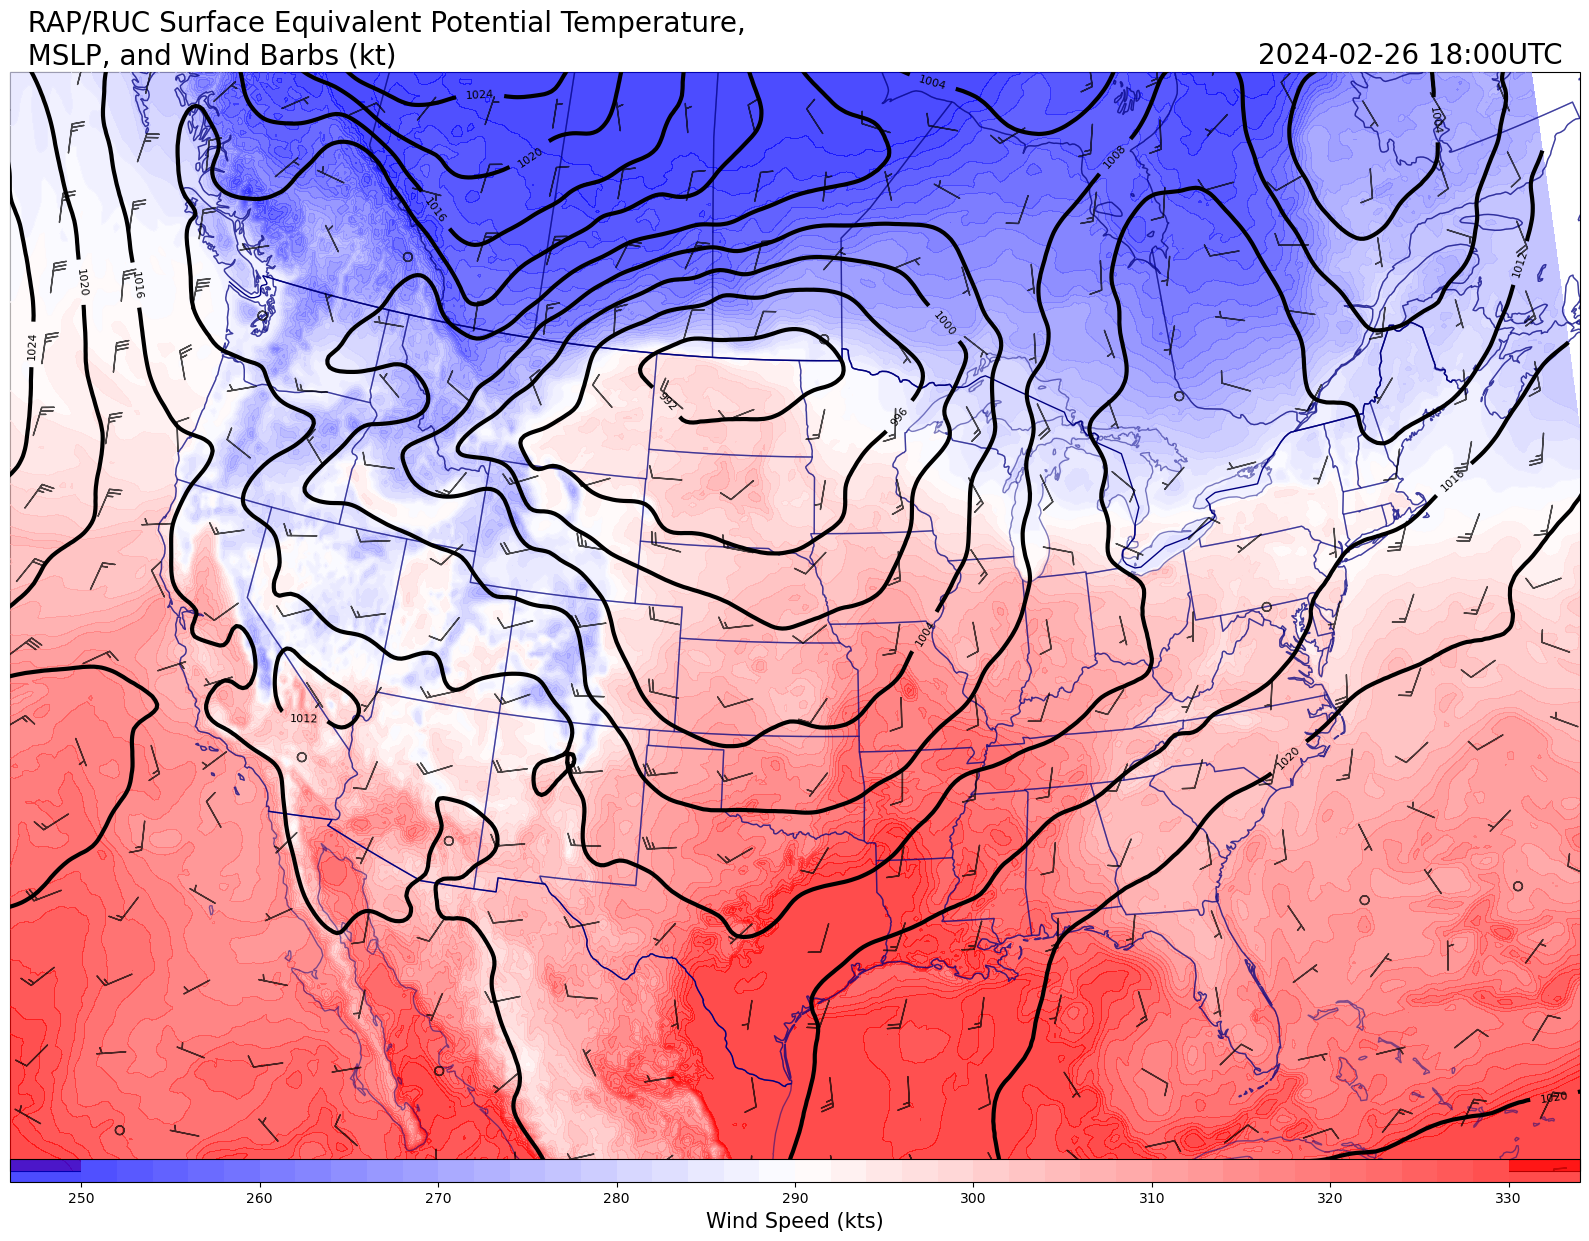

In [11]:
#################################
# BUILD AXIS AND FIGURE
#################################
fig, ax = build_map()

#################################
# PLOT DATA ON THE MAP
#################################

# plot filled contours of equivalent potential temperature
contourf = ax.contourf(rap_data['lon'], rap_data['lat'], rap_data['theta_e_sfc'][0], np.arange(250, 331, 2), extend='both',
                 cmap='bwr', alpha=0.7, transform=ccrs.PlateCarree(), zorder=4)



# plot MSLP
contour = ax.contour(rap_data['lon'], rap_data['lat'], rap_data['MSLP'][0,:,:].metpy.convert_units('hPa'), np.arange(800, 1100, 4),
                colors='black', linewidths=3.0, linestyles='-',
                transform=ccrs.PlateCarree(), zorder=11)
plt.clabel(contour, fontsize=8, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)


# plot wind barbs
every = 20
barbs = ax.barbs(rap_data['lon'].values[0::every, 0::every], rap_data['lat'].values[0::every, 0::every],
                 rap_data['u-component_of_wind_isobaric'][0,-1,:,:][0::every, 0::every].metpy.convert_units('kts').values, 
                 rap_data['v-component_of_wind_isobaric'][0,-1,:,:][0::every, 0::every].metpy.convert_units('kts').values,
                 length=6.5, alpha=0.7, transform=ccrs.PlateCarree(), zorder=12)


# add some plot titles
plt.title('  RAP/RUC Surface Equivalent Potential Temperature,\n'
          '  MSLP, and Wind Barbs (kt)', loc='left', fontsize=20)
plt.title(f'{valid_date[0:10]} {valid_date[11:-13]}UTC  ', loc='right', fontsize=20)


# colorbar for filled contour
cbar = plt.colorbar(contourf, aspect=70, fraction=0.02, ax=ax, orientation='horizontal', pad=-0.01, extendrect=True)
cbar.set_label(r'Wind Speed (kts)', fontsize=15)

print("\n[+] plotting...")

**************

# **CROSS SECTION ANALYSIS**
<br>

#### 1. Use MetPy's `cross_section` to create variables of "sliced" cross section data
#### 2. Plot cross section analyses of PV and static stability

<br>
<br>

## 1. Compute Cross Section Data 

In [46]:
#################################
# COMPUTE CROSS SECTION USING METPY
#################################
# define the start and end point of the cross section
start = (43.4, -96.7)
end = (48.4, -89.4)

# use metpy's `cross_section` to create a new DataSet of cross section "2D" data
cs_data = cross_section(rap_data.metpy.parse_cf().squeeze(), start, end).set_coords(('lat', 'lon'))

# using the cross section DataSet, calculate the normal component of the wind to the cross section plane
cs_data['nwind'] = mpcalc.normal_component(cs_data['u-component_of_wind_isobaric'], cs_data['v-component_of_wind_isobaric'])

print("\n[+] data preparation complete...")



[+] data preparation complete...


**************

## 2. Theta-E Cross Section

/tmp/ipykernel_260795/1312923667.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(1000, 500, -50))



[+] plotting...


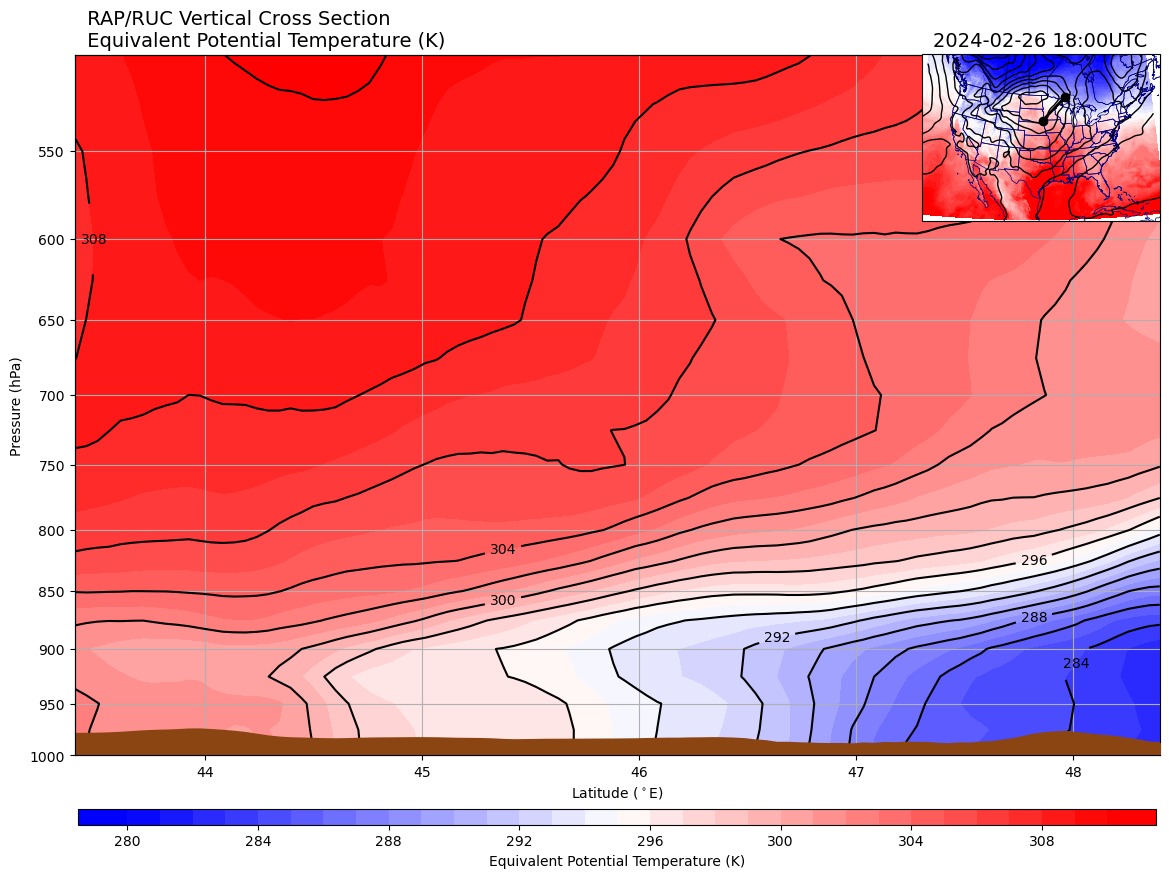

In [47]:
#################################
# CREATE SIMPLE FIGURE
#################################
fig = plt.figure(1, figsize=(14, 10))
ax = plt.subplot(111)


#################################
# PLOT CROSS SECTION DATA
#################################
# plot contourf of PV
theta_e_contourf = plt.contourf(cs_data['lat'], cs_data['isobaric'].metpy.convert_units('hPa'), cs_data['theta_e'], np.arange(280,311), extend='both', cmap='bwr')
theta_e_contour = plt.contour(cs_data['lat'], cs_data['isobaric'].metpy.convert_units('hPa'), cs_data['theta_e'], np.arange(200,400,2), colors='k')

# plot contour of normal-wind to cross section plane, add labels
#nwnd_contour = plt.contour(cs_data['lon'], cs_data['isobaric'].metpy.convert_units('hPa'), cs_data['nwind']* 1.94384 , colors='black',linewidths=2)
labels = plt.clabel(theta_e_contour, theta_e_contour.levels[::2], fontsize=10, inline=True,fmt = '%1.0f')
for l in labels:
    l.set_rotation(0)

#################################
# MANIPULATE PLOT AXIS, ADD GRID
#################################
ax.grid(True)
ax.set_yscale('symlog')
ax.set_ylim([1000,500])
ax.set_yticklabels(np.arange(1000, 500, -50))
ax.set_yticks(np.arange(1000, 500, -50))

#################################
# ADD PLOT AXIS LABELS AND TITLES
#################################
plt.ylabel('Pressure (hPa)')
plt.xlabel(r'Latitude $\rm{(^\circ E)}$')
plt.title('  RAP/RUC Vertical Cross Section\n  Equivalent Potential Temperature (K)', loc='left', fontsize=14)
plt.title(f'{valid_date[0:10]} {valid_date[11:-13]}UTC  ', loc='right', fontsize=14)

#################################
# ADD FILLED CONTOUR COLORBAR
#################################
cbar = plt.colorbar(theta_e_contourf, aspect=70, fraction=0.02, ax=ax, orientation='horizontal', pad=0.07, extendrect=True)
cbar.set_label(r'Equivalent Potential Temperature (K)', fontsize=10)

#################################
# CREATE A 2ND AXIS TO PLOT TERRAIN
#################################
# Create the second axis, hide it, set y limit
# plot sfc hghts - 1000hPa hght for a 1000hPa-100hPa yaxis 
ax2 = ax.twinx()
ax2.get_yaxis().set_visible(False)   
ax2.spines['right'].set_visible(False)
ax2.set_ylim([0,15000])
ax2.plot(cs_data['lat'], cs_data['Geopotential_height_surface'] - cs_data['Geopotential_height_isobaric'][-1], color='saddlebrown')
ax2.fill_between(cs_data['lat'], 0, cs_data['Geopotential_height_surface']- cs_data['Geopotential_height_isobaric'][-1], color='saddlebrown')




#################################
# BUILD AND PLOT MAP INSET
#################################
inset_ax = build_inset_map()
# define map projection
inset_projection = ccrs.LambertConformal()

# PLOT CROSS SECTION POINTS
endpoints = inset_projection.transform_points(ccrs.Geodetic(),*np.vstack([start, end]).transpose()[::-1])
inset_ax.scatter(endpoints[:, 0], endpoints[:, 1], c='k', zorder=2)
inset_ax.plot(endpoints[:,0], endpoints[:,1], c='k', zorder=2, lw=2)

# PLOT 300hPa GEOPOTENTIAL HEIGHTS CONTOUR
cs = inset_ax.contour(rap_data['lon'], rap_data['lat'], rap_data['MSLP'][0, :, :].metpy.convert_units('hPa'), np.arange(800, 1100, 4),
                      colors='black',transform=ccrs.PlateCarree(), linewidths=1)

# PLOT 300hPa PV CONTOURF
inset_contourf = inset_ax.contourf(rap_data['lon'], rap_data['lat'], rap_data['theta_e_sfc'][0, :, :], np.arange(250, 331, 2), cmap='bwr',
                                   transform=ccrs.PlateCarree(), extend='both')

print("\n[+] plotting...")


plt.savefig('warm_front.png',bbox_inches='tight')